In [1]:
import os
import json

In [2]:
if not os.path.exists('/content/data/'):

  api_token = {"username": "prabeshsharma",
                  "key": "e8929420b0f14df13c668815eef404a0"}

  with open('/content/kaggle.json', 'w') as file:
      json.dump(api_token, file)

  os.environ["KAGGLE_CONFIG_DIR"] = "/content/"

  os.system('kaggle datasets download -d prabeshsharma/vgg16featureextraction-ucfcrime-data')
  os.makedirs('/content/data/', exist_ok=True)
  os.system('mv /content/vgg16featureextraction-ucfcrime-data.zip /content/data/vgg16featureextraction-ucfcrime-data.zip')
  os.system('unzip -q /content/data/vgg16featureextraction-ucfcrime-data.zip -d /content/data/')
  os.remove('/content/data/vgg16featureextraction-ucfcrime-data.zip')

In [3]:
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

In [4]:
import numpy as np
import pickle
import os
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Path to the directory containing pickle files for each video
train_data_dir = '/content/data/Vgg16FeatureExtractedData/TrainFeature'
test_data_dir = '/content/data/Vgg16FeatureExtractedData/TestFeature'

def load_data_with_class_names(data_dir):
    features, labels = [], []

    # Iterate through the class directories
    for class_dir in os.listdir(data_dir):
        if class_dir == 'NormalVideos':
            continue  # Skip NormalVideos class

        class_path = os.path.join(data_dir, class_dir)

        # Iterate through the files in the class directory
        for file in os.listdir(class_path):
            file_path = os.path.join(class_path, file)

            # Load video features (assumed to be numpy arrays)
            with open(file_path, 'rb') as f:
                video_features = pickle.load(f)

            features.append(video_features)

            # Label with the actual class name (e.g., 'Abuse', 'Arson', etc.)
            labels.append(class_dir)

    # Find the maximum sequence length
    max_length = 500  # Modify this if necessary

    # Pad all features to have the same length
    features_padded = pad_sequences(features, maxlen=max_length, padding='post', dtype='float32')

    return np.array(features_padded), np.array(labels)

  # Load the training and testing data
Trainfeatures, Trainlabels = load_data_with_class_names(train_data_dir)
Testfeatures, Testlabels = load_data_with_class_names(test_data_dir)

# Convert labels to one-hot encoding for binary classification
encoder = LabelEncoder()
Trainlabels= to_categorical(encoder.fit_transform(Trainlabels))
Testlabels = to_categorical(encoder.transform(Testlabels))

print("Training Features Shape:", Trainfeatures.shape)
print("Training Labels Shape:", Trainlabels.shape)
print("Test Features Shape:", Testfeatures.shape)
print("Test Labels Shape:", Testlabels.shape)


Training Features Shape: (665, 500, 512)
Training Labels Shape: (665, 13)
Test Features Shape: (140, 500, 512)
Test Labels Shape: (140, 13)


In [5]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Define a custom transformer encoder layer
class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerEncoder, self).__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim, output_shape=embed_dim)
        self.ffn = models.Sequential(
            [
                layers.Dense(ff_dim, activation="relu"),
                layers.Dense(embed_dim)  # FFN output matches embed_dim
            ]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training=None):
        # Multi-head self-attention layer
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)  # Residual connection + normalization

        # Feed-forward network
        ffn_output = self.ffn(out1)  # FFN output dimension matches embed_dim
        ffn_output = self.dropout2(ffn_output, training=training)

        # Residual connection + normalization
        return self.layernorm2(out1 + ffn_output)

# Define the Transformer-based model
def create_transformer_model(input_shape, embed_dim=512, num_heads=8, ff_dim=512):
    inputs = layers.Input(shape=input_shape)

    # Transformer Encoder block
    x = TransformerEncoder(embed_dim, num_heads, ff_dim)(inputs)

    # Global pooling to reduce sequence dimension
    x = layers.GlobalAveragePooling1D()(x)

    # Dense layers for classification
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.5)(x)  # Dropout to prevent overfitting
    outputs = layers.Dense(13, activation='softmax')(x)  # 13 output units for multi-class classification

    model = models.Model(inputs=inputs, outputs=outputs)

    # Compile the model
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)

    model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model


# Create the transformer model
input_shape = (Trainfeatures.shape[1], Trainfeatures.shape[2])  # e.g., (n_frames, feature_dim)
transformer_model = create_transformer_model(input_shape)

# Model summary
transformer_model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 500, 512)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ transformer_encoder                  │ (None, 500, 512)            │       8,928,768 │
│ (TransformerEncoder)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d             │ (None, 512)                 │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │          65,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 13)                  │           1,677 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,996,109 (34.32 MB)

 Trainable params: 8,996,109 (34.32 MB)

 Non-trainable params: 0 (0.00 B)

In [8]:
# from tensorflow.keras.callbacks import ModelCheckpoint

# # Define the callback to save the model based on the highest validation accuracy
# checkpoint = ModelCheckpoint('best_model.keras',
#                              monitor='val_accuracy',
#                              verbose=1,
#                              save_best_only=True,
#                              mode='max')

In [9]:
# Train the model
history = transformer_model.fit(Trainfeatures, Trainlabels,
                                epochs=10,
                                batch_size=32,
                                validation_data=(Testfeatures, Testlabels))

Epoch 1/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.1165 - loss: 2.8378 - val_accuracy: 0.0786 - val_loss: 2.5437
Epoch 2/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 10s 308ms/step - accuracy: 0.1724 - loss: 2.4703 - val_accuracy: 0.1000 - val_loss: 2.5406
Epoch 3/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 6s 305ms/step - accuracy: 0.1291 - loss: 2.5217 - val_accuracy: 0.0714 - val_loss: 2.6054
Epoch 4/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 10s 308ms/step - accuracy: 0.1678 - loss: 2.4899 - val_accuracy: 0.1286 - val_loss: 2.5655
Epoch 5/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 10s 314ms/step - accuracy: 0.1640 - loss: 2.4537 - val_accuracy: 0.1571 - val_loss: 2.5217
Epoch 6/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 10s 312ms/step - accuracy: 0.2015 - loss: 2.4415 - val_accuracy: 0.1500 - val_loss: 2.5218
Epoch 7/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 10s 319ms/step - accuracy: 0.1781 - loss: 2.4649 - val_accuracy: 0.1429 - val_loss: 2.5349
Epoch 8/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 10s 316ms/step - accuracy: 0.1684 - loss: 2.4122 - val_accuracy

In [10]:
# Evaluate the model on the validation set
val_loss, val_acc = transformer_model.evaluate(Testfeatures, Testlabels, verbose=2)
print(f"Validation accuracy: {val_acc:.4f}")


5/5 - 1s - 126ms/step - accuracy: 0.1500 - loss: 2.5410
Validation accuracy: 0.1500


In [11]:
import matplotlib.pyplot as plt
def plot_graphs(histoy, string):
    plt.plot(histoy.history[string])
    plt.plot(histoy.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string,'val_'+string])
    plt.show()

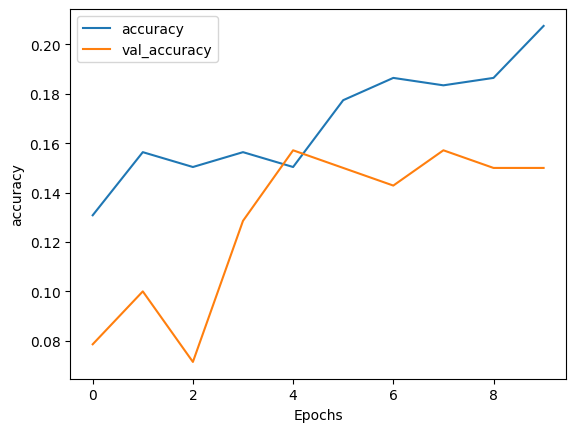

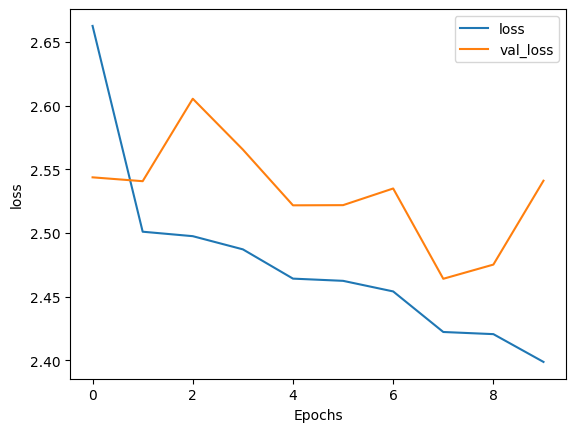

In [12]:
plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')

In [13]:
transformer_model.save('transformer_video_classifierAbnormal.h5')